In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


PROMPT_EMBED SHAPES: prompt_embeds: torch.Size([1, 333, 4096]), pooled_prompt_embeds: torch.Size([1, 2048])


  0%|          | 0/28 [00:00<?, ?it/s]

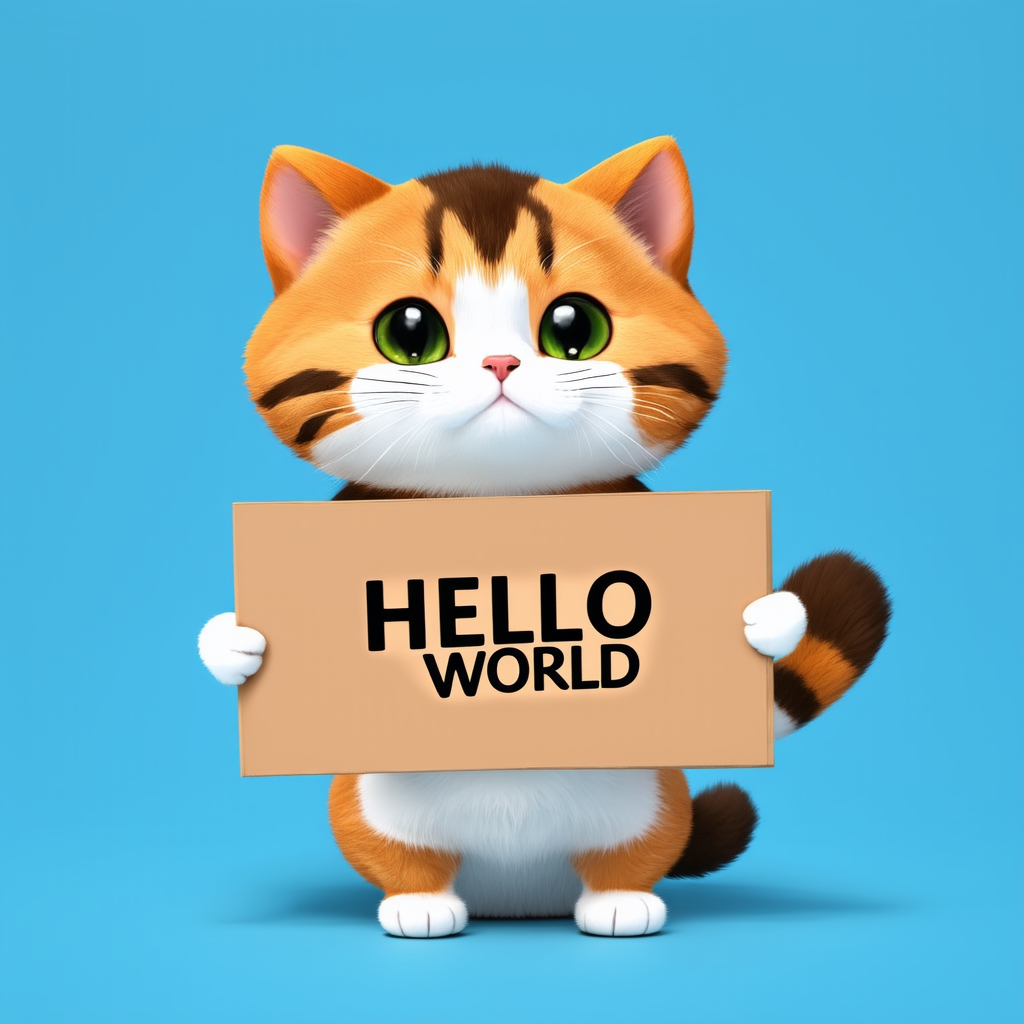

In [3]:
import torch
from stable_diffusion3 import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

PROMPT_EMBED SHAPES: prompt_embeds: torch.Size([1, 154, 4096]), pooled_prompt_embeds: torch.Size([1, 2048])


  0%|          | 0/28 [00:00<?, ?it/s]

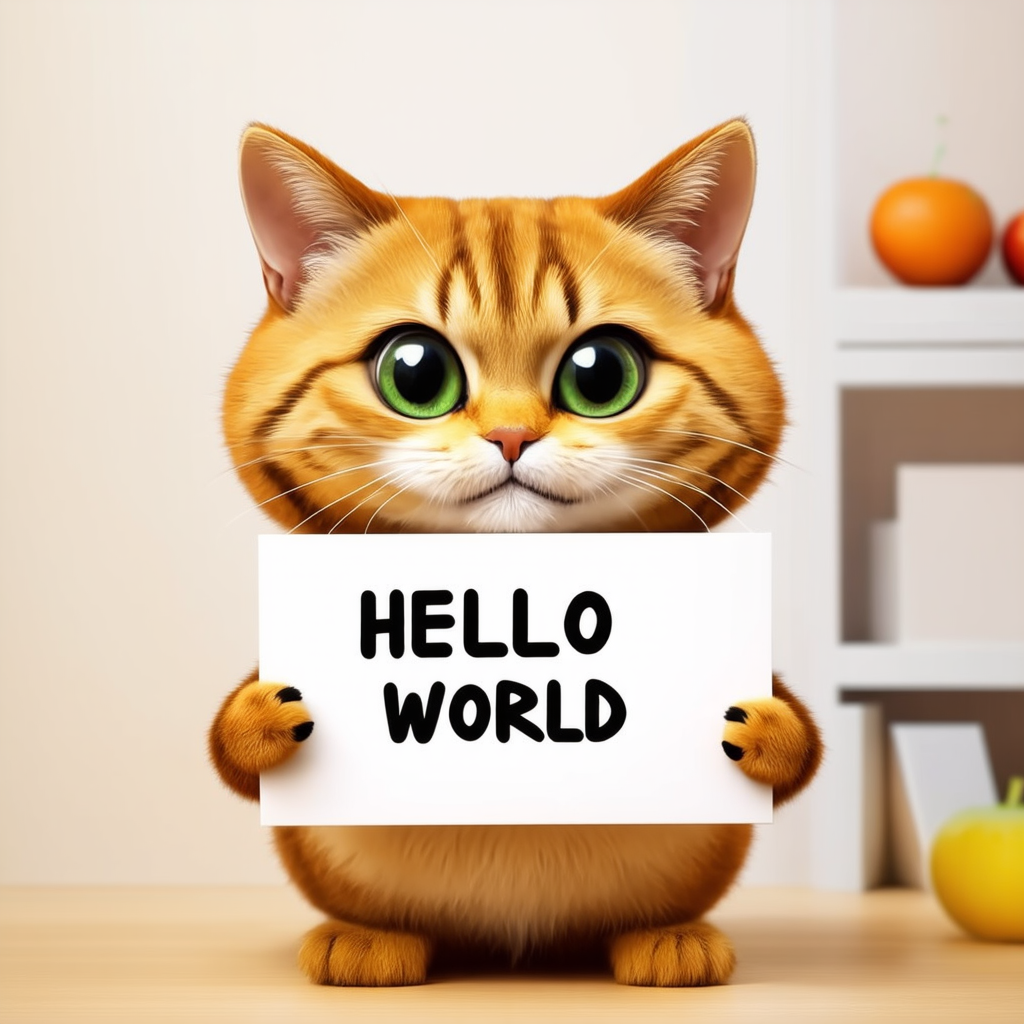

In [4]:
pipe.text_encoder_3 = None

image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    # output_type='pt'
).images[0]
image

In [5]:
import open_clip

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k')
tokenizer = open_clip.get_tokenizer('hf-hub:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k')

model = model.cuda()

/home/tiger/.local/lib/python3.9/site-packages/bytedmetrics/__init__.py:10: UserWarning: bytedmetrics is renamed to bytedance.metrics, please using `bytedance.metrics` instead of `bytedmetrics`
  warnings.warn("bytedmetrics is renamed to bytedance.metrics, please using `bytedance.metrics` instead of `bytedmetrics`")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The curren

In [6]:
import inspect
inspect.signature(tokenizer.encode)

<Signature (text)>

In [7]:
with torch.no_grad():
    im_processed = preprocess_val(image).cuda()
    model.visual.output_tokens = True
    out = model.visual(im_processed[None])

    # CLIP-ViT-bigG-14-laion2B-39B-b160k performs 'pooling' by simply taking the embedding at the first position
    print(out[0].shape, out[1].shape)

torch.Size([1, 1280]) torch.Size([1, 256, 1664])


In [8]:
model.text_pool_type

'argmax'

In [39]:
from open_clip.transformer import text_global_pool
from torch import nn

def encode_text(self, text, normalize: bool = False):
    cast_dtype = self.transformer.get_cast_dtype()

    x = self.token_embedding(text).to(cast_dtype)  # [batch_size, n_ctx, d_model]

    x = x + self.positional_embedding.to(cast_dtype)
    print("HEY", x.shape, x.min(), x.max())
    x = self.transformer(x, attn_mask=self.attn_mask)
    # x = self.ln_final(x)  # [batch_size, n_ctx, transformer.width]
    # x, tok = text_global_pool(x, text, self.text_pool_type)
    # if self.text_projection is not None:
    #     if isinstance(self.text_projection, nn.Linear):
    #         x = self.text_projection(x)
    #     else:
    #         x = x @ self.text_projection

    return F.normalize(x, dim=-1) if normalize else x, tok

In [40]:
with torch.no_grad():
    tokens = tokenizer(["A cat holding a sign that says hello world"])
    tokens = torch.tensor(tokens, device='cuda')
    model.transformer.output_tokens = True
    # out = model.transformer(tokens)
    out, tok = encode_text(model, tokens)

HEY torch.Size([1, 77, 1280]) tensor(-1.3772, device='cuda:0') tensor(0.1651, device='cuda:0')


/tmp/ipykernel_316697/699150448.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, device='cuda')


In [44]:
prompt_embeds, pooled_prompt_embeds = pipe._get_clip_prompt_embeds("A cat holding a sign that says hello world", clip_model_index=1)

In [63]:
prompt = "A cat holding a sign that says hello world"
text_inputs = pipe.tokenizer_2(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer_max_length,
    truncation=True,
    return_tensors="pt",
)

text_input_ids = text_inputs.input_ids
prompt_embeds = pipe.text_encoder_2(text_input_ids.to('cuda'), output_hidden_states=True)

In [66]:
(prompt_embeds.last_hidden_state - tok).norm() / tok.norm()

tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)

In [68]:
(prompt_embeds.hidden_states[-1] - prompt_embeds.last_hidden_state).norm()

tensor(221.6250, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)

In [1]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

clip_vit_large_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
clip_vit_large_model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]